In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2lab, lab2rgb, gray2rgb
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
TRAIN_DIR = "../input/train/"
TARGET_SIZE = (224,224)
BATCH_SIZE = 16  # You can adjust this based on your GPU memory

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, zoom_range=0.2,
                                   rotation_range=20, horizontal_flip=True
                                  )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=TARGET_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode=None)

Found 7129 images belonging to 1 classes.


In [3]:
base_model = InceptionResNetV2(include_top=False, weights='imagenet', 
                               input_shape=(224, 224, 3))

base_model.trainable = False

# base_model.summary()
base_model.layers[-1].output_shape

(None, 5, 5, 1536)

In [4]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [5]:
# Convert RGB images to LAB format and separate L and AB channels
def preprocess_lab(image_batch):
    lab_batch = rgb2lab(image_batch)
    X_batch = lab_batch[:, :, :, 0]  # L channel
    Y_batch = lab_batch[:, :, :, 1:] / 128  # AB channels between -1 and 1
    X_batch = X_batch.reshape(X_batch.shape + (1,))  # Add channel dimension for grayscale
    return X_batch, Y_batch

# Process the data in batches and extract VGG features
def extract_vgg_features(generator, model):
    vgg_features = []
    Y_targets = []  # Collect the target data for each batch
    for batch in generator:
        X_batch, Y_batch = preprocess_lab(batch)
        vgg_batch = model.predict(batch, verbose=0)  # Use the original 3-channel image for VGG
        vgg_features.append(vgg_batch)
        Y_targets.append(Y_batch)
        if len(vgg_features) * BATCH_SIZE >= len(generator.filenames):
            break
    return np.concatenate(vgg_features, axis=0), np.concatenate(Y_targets, axis=0)

In [6]:
%%time

# Extract VGG features and target data from the training data
vgg_features, Y = extract_vgg_features(train_generator, base_model)
vgg_features.shape, Y.shape

CPU times: total: 2min 17s
Wall time: 3min 9s


((7129, 5, 5, 1536), (7129, 224, 224, 2))

In [7]:
base_model.layers[-1].output_shape[1:]

(5, 5, 1536)

In [8]:
steps_per_epoch = len(vgg_features)//BATCH_SIZE
steps_per_epoch

445

In [9]:
# Define the deencoder model
model = models.Sequential(name='decoder_model')

# input_shape=(7,7,512) --> This is the o/p shape of encoder i.e. VGG16 model
# model.add(layers.Conv2D(512, (3,3), 
#                         activation='relu', 
#                         padding='same', 
#                         input_shape=(7,7,512)))

model.add(layers.InputLayer(input_shape=base_model.layers[-1].output_shape[1:]))

model.add(layers.Conv2D(448, (3,3), strides=2, activation='relu', padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, 3, 2, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.UpSampling2D((7,7)))

model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.UpSampling2D((2, 2)))

model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.UpSampling2D((2, 2)))

model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.UpSampling2D((2, 2)))

model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.UpSampling2D((2, 2)))

model.add(layers.Conv2D(2, (3, 3), activation='relu', padding='same'))
# model.add(layers.UpSampling2D((2, 2)))

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), 
              loss='mse', 
              metrics=['accuracy'])

model.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_203 (Conv2D)         (None, 3, 3, 448)         6193600   
                                                                 
 batch_normalization_203 (Ba  (None, 3, 3, 448)        1792      
 tchNormalization)                                               
                                                                 
 conv2d_204 (Conv2D)         (None, 2, 2, 256)         1032448   
                                                                 
 batch_normalization_204 (Ba  (None, 2, 2, 256)        1024      
 tchNormalization)                                               
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                     

In [10]:
%%time

# Train the decoder
history = model.fit(vgg_features, Y,
                    verbose=1,
                    epochs=10, 
                    batch_size=16, steps_per_epoch=steps_per_epoch,
                    workers=10)

Epoch 1/10
445/445 [==============================] - 11s 20ms/step - loss: 0.0691 - accuracy: 0.5459
Epoch 2/10
445/445 [==============================] - 9s 21ms/step - loss: 0.0136 - accuracy: 0.5879
Epoch 3/10
445/445 [==============================] - 9s 21ms/step - loss: 0.0123 - accuracy: 0.6117
Epoch 4/10
445/445 [==============================] - 9s 21ms/step - loss: 0.0117 - accuracy: 0.6290
Epoch 5/10
445/445 [==============================] - 9s 21ms/step - loss: 0.0115 - accuracy: 0.6398
Epoch 6/10
445/445 [==============================] - 9s 21ms/step - loss: 0.0112 - accuracy: 0.6517
Epoch 7/10
445/445 [==============================] - 9s 21ms/step - loss: 0.0109 - accuracy: 0.6583
Epoch 8/10
445/445 [==============================] - 9s 21ms/step - loss: 0.0108 - accuracy: 0.6641
Epoch 9/10
445/445 [==============================] - 9s 21ms/step - loss: 0.0106 - accuracy: 0.6731
Epoch 10/10
445/445 [==============================] - 9s 21ms/step - loss: 0.0103 - accur

In [11]:
test = img_to_array(load_img('../input/test/t2.jpg'))

test = resize(test, (224,224),)
test*= 1.0/255

lab = rgb2lab(test)

l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1,224,224,3))

vgg_pred = base_model.predict(L)
ab = model.predict(vgg_pred)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab

colored_img = lab2rgb(cur)

1/1 [==============================] - 0s 219ms/step


C:\Users\Amit Vikram Raj\AppData\Local\Temp\ipykernel_11292\197585500.py:19: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 388 negative Z values that have been clipped to zero
  colored_img = lab2rgb(cur)


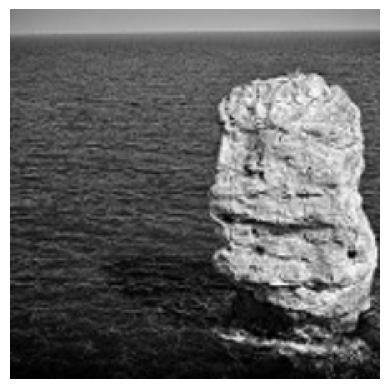

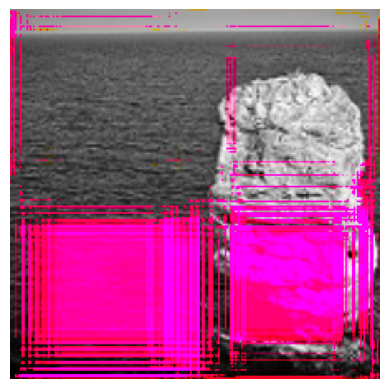

In [12]:
plt.figure()
plt.imshow(test)
plt.axis("off");

plt.figure()
plt.imshow(colored_img)
plt.axis("off");

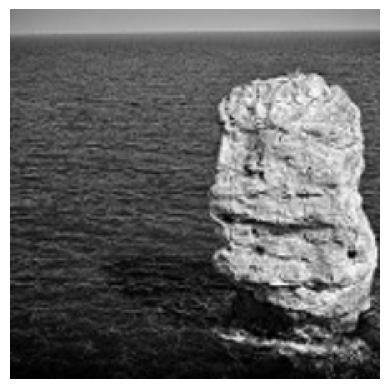

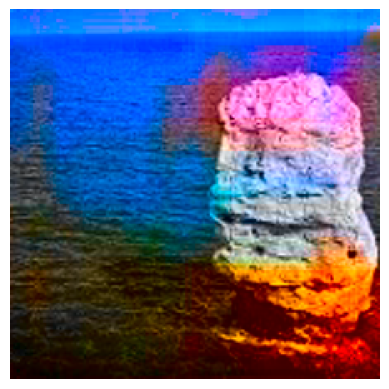

In [12]:
plt.figure()
plt.imshow(test)
plt.axis("off");

plt.figure()
plt.imshow(colored_img)
plt.axis("off");